# Praca domowa 3-WB

In [65]:
import numpy as np 
import pandas as pd 
import pydicom,os,cv2
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd 
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.ndimage
import imquality.brisque as brisque
import PIL.Image

# Siim

## Dane jakościowe

In [79]:
train_fns = sorted(glob('C:/Users/maaja/Desktop/AndrzejczukMaja/archive/siim/dicom-images-train/*/*/*.dcm'))
test_fns = sorted(glob('C:/Users/maaja/Desktop/AndrzejczukMaja/archive/siim/dicom-images-test/*/*/*.dcm'))
df = pd.read_csv('C:/Users/maaja/Desktop/AndrzejczukMaja/archive/siim/train-rle.csv')

Normal = sorted(glob('C:/Users/maaja/Desktop/AndrzejczukMaja/ZhangLabData/CellData/chest_xray/train/NORMAL/*.jpeg'))
Pneumonia = sorted(glob('C:/Users/maaja/Desktop/AndrzejczukMaja/ZhangLabData/CellData/chest_xray/train/PNEUMONIA/*.jpeg'))

czy są artefakty (łańcuszki, guziki) na obrazach, przykłady - tylko pokaż może

In [29]:
def plot_pixels(dataset, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()


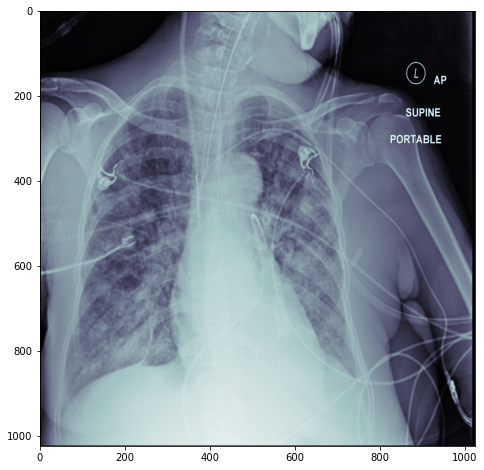

In [34]:
data = pydicom.dcmread(train_fns[3])
plot_pixels(data)

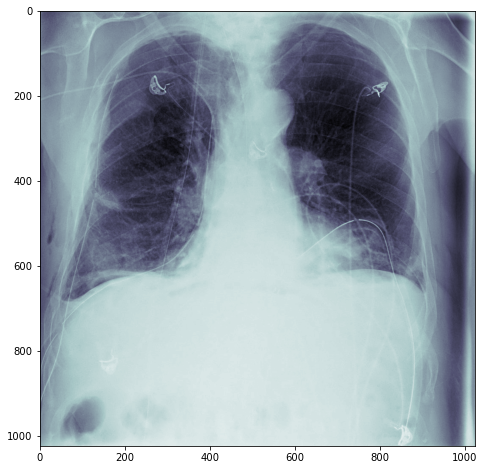

In [39]:
data = pydicom.dcmread(train_fns[13])
plot_pixels(data)

Czy litery na obrazach?

Na niektórych zdjęciach występują

Rozmiary zdjęć:

Wszystkie zdjęcia są 1024 na 1024

różnice pomiędzy zbiorem treningowym a testowym

nie ma znaczących różnic

### te nakladanie masek

## Analiza Obrazów

Histogram dla 10 zdjęć 

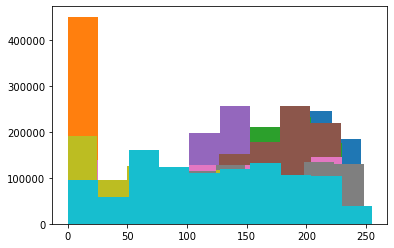

In [122]:
for i in range (10):
    img =  pydicom.dcmread(train_fns[i]).pixel_array
    plt.hist(np.ravel(img))

jakie są wartości pikseli w obrazach, czy w przedziale 0-1, czy 0-255, czy może inny zakres? czy każde zdjęcie ma wartości skrajne? jak sądzicie dlaczego tak jest?

In [91]:
zdj = pydicom.dcmread(train_fns[3]).pixel_array

xray_image = zdj
print("The data type of the X-ray image is: ", xray_image.dtype)
print("The minimum pixel value is: ", np.min(xray_image))
print("The maximum pixel value is: ", np.max(xray_image))
print("The average pixel value is: ", np.mean(xray_image))
print("The median pixel value is: ", np.median(xray_image))

The data type of the X-ray image is:  uint8
The minimum pixel value is:  0
The maximum pixel value is:  255
The average pixel value is:  125.84577751159668
The median pixel value is:  134.0


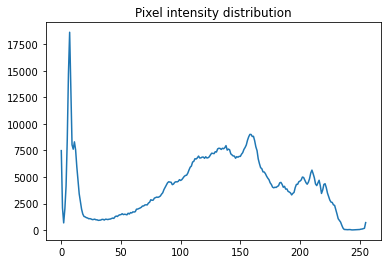

In [92]:
from scipy import ndimage
pixel_intensity_distribution = ndimage.histogram(
    xray_image, min=np.min(xray_image), max=np.max(xray_image), bins=256
)

plt.plot(pixel_intensity_distribution)
plt.title("Pixel intensity distribution")
plt.show()

Wyniki wartości minimalnej/maksymalnej sugerują, że wszystkie 256 kolorów (od 0 do 255) jest używanych w promieniowaniu rentgenowskim. Wizualizacja potwierdzila

In [54]:
missing = 0
multiple = 0
patients_data = []
for k,paths in enumerate(train_fns):
    patient = {}
    img_id = paths.split('\\')[-1]
    data = pydicom.dcmread(paths)
    try:
        tmp = df[df['ImageId'] == '.'.join(img_id.split('.')[:-1])]
        
        if tmp.shape[0] > 1: 
            multiple += 1
        rle = tmp[' EncodedPixels'].values
        if rle[0] == '-1':
            pixels = rle[0]
        else:    
            pixels = [i for i in rle]
        
        patient["UID"] = data.SOPInstanceUID
        patient['EncodedPixels'] = pixels
        patient["Age"] = data.PatientAge
        patient["Sex"] = data.PatientSex
        patient["Modality"] = data.Modality
        patient["BodyPart"] = data.BodyPartExamined
        patient["ViewPosition"] = data.ViewPosition
        patient["filepath"] = paths
        patients_data.append(patient)
    except:
        missing += 1

In [55]:
df_patients = pd.DataFrame(patients_data, columns=["UID", "EncodedPixels", "Age", 
                            "Sex", "Modality", "BodyPart", "ViewPosition", "filepath"])

df_patients['Pneumothorax'] = df_patients['EncodedPixels'].apply(lambda x:0 if x == '-1' else 1)
df_patients['Pneumothorax'] = df_patients['Pneumothorax'].astype('int')
df_patients.head() 

,UID,EncodedPixels,Age,Sex,Modality,BodyPart,ViewPosition,filepath,Pneumothorax
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,-1,38,M,CR,CHEST,PA,C:/Users/maaja/Desktop/AndrzejczukMaja/archive...,0
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,-1,10,F,CR,CHEST,AP,C:/Users/maaja/Desktop/AndrzejczukMaja/archive...,0
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,-1,50,F,CR,CHEST,AP,C:/Users/maaja/Desktop/AndrzejczukMaja/archive...,0
3,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,-1,68,F,CR,CHEST,AP,C:/Users/maaja/Desktop/AndrzejczukMaja/archive...,0
4,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,-1,65,M,CR,CHEST,AP,C:/Users/maaja/Desktop/AndrzejczukMaja/archive...,0


In [96]:
def rle2mask(rles, width, height):
    mask= np.zeros(width* height)
    for rle in rles:
        array = np.asarray([int(x) for x in rle.split()])
        starts = array[0::2]
        lengths = array[1::2]

        current_position = 0
        for index, start in enumerate(starts):
            current_position += start
            mask[current_position:current_position+lengths[index]] = 255
            current_position += lengths[index]

    return mask.reshape(width, height).T

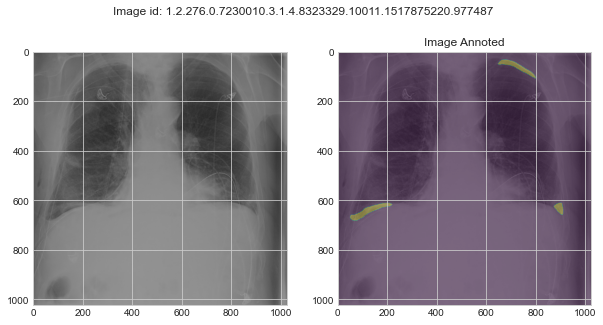

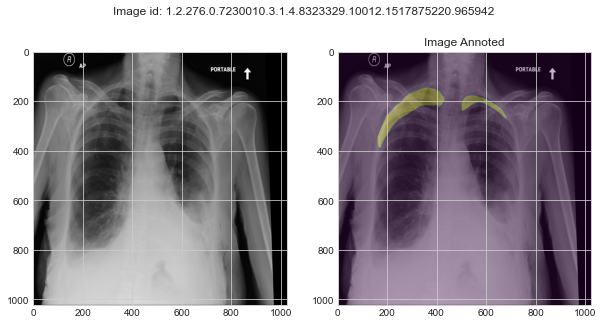

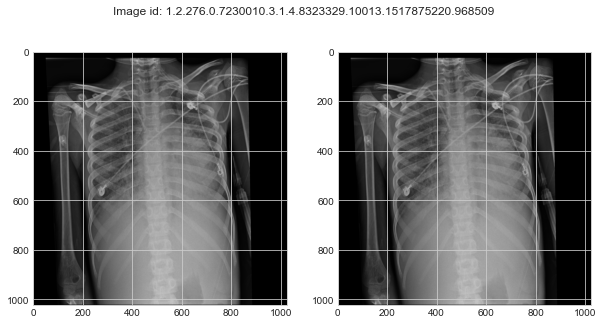

In [137]:
for file in train_fns[13:16]:
    data = pydicom.dcmread(file)
    image = data.pixel_array
    id_ = '.'.join(file.split('\\')[-1].split('.')[:-1])
    rle = df[df['ImageId'] == str(id_)][' EncodedPixels'].values
    if rle[0] == '-1':
        fig,axes = plt.subplots(1,2,figsize=(10,5))
        axes[0].imshow(cv2.cvtColor(image,cv2.COLOR_GRAY2RGB),cmap='bone')
        axes[1].imshow(cv2.cvtColor(image,cv2.COLOR_GRAY2RGB),cmap='bone')
        plt.suptitle(f'Image id: {id_}')
        plt.show()
    else:
        fig,axes = plt.subplots(1,2,figsize=(10,5))
        axes[0].imshow(cv2.cvtColor(image,cv2.COLOR_GRAY2RGB),cmap='bone')
        mask = rle2mask(rle,image.shape[0],image.shape[1])
        axes[1].imshow(cv2.cvtColor(image,cv2.COLOR_GRAY2RGB),cmap='bone')
        axes[1].imshow(mask,alpha=0.3,cmap='viridis')
        axes[1].set_title('Image Annoted')
        plt.suptitle(f'Image id: {id_}')
        plt.show()

Rozmiar zmiany chorobowej w stosunku do wielkości zdjęcia :

Mam wszystkie zdjecia tej samej wielkości

czy wszystkie zdjęcia są monochrome2 lub monochrome1?

W Siim mamy monochrome 2

czy wszystkie zdjęcia są dla pacjentów w pionie?

tak

Zdjęcia jedno czy trzykanałowe?

In [106]:

img = pydicom.dcmread(train_fns[5]).pixel_array
img.shape[-1] if img.ndim == 3 else 1

1

Zdjęcia jednokanałowe

## Zależności

czy AP u chorych, PA u zdrowych?

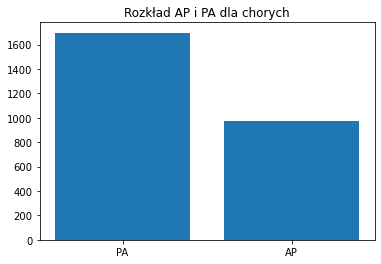

In [57]:
non_healthy = df_patients[df_patients['Pneumothorax'] == 1]
a = non_healthy['ViewPosition'].value_counts()

x = list(a.index)
y = list(a)

plt.bar(x, y)
plt.title("Rozkład AP i PA dla chorych")
plt.show()

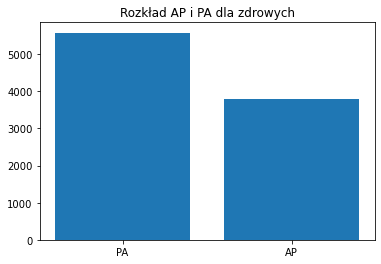

In [59]:
healthy = df_patients[df_patients['Pneumothorax'] == 0]
a = healthy['ViewPosition'].value_counts()

x = list(a.index)
y = list(a)

plt.bar(x, y)
plt.title("Rozkład AP i PA dla zdrowych")
plt.show()

zależność wieku od choroby

C:\Users\maaja\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\maaja\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\maaja\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

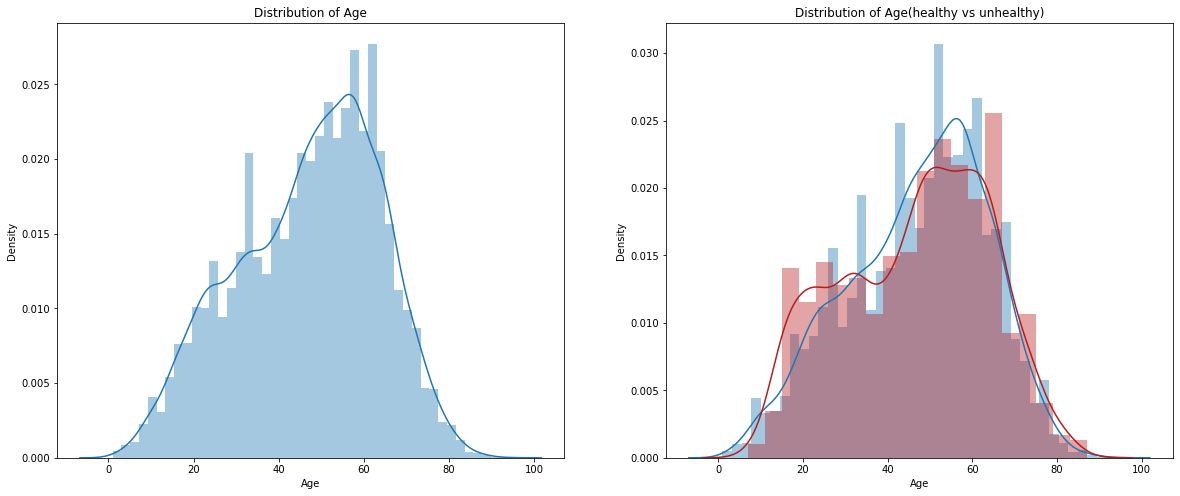

In [38]:
df_patients = df_patients.drop(df_patients[df_patients['Age'] > 100].index)
non_healthy = df_patients[df_patients['Pneumothorax'] == 1] 
healthy = df_patients[df_patients['Pneumothorax'] == 0]

df_patients['Age'] = df_patients['Age'].astype('int') 
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,8))
sns.distplot(df_patients['Age'],ax=axes[0])
axes[0].title.set_text('Distribution of Age')
sns.distplot(healthy['Age'],ax=axes[1])
sns.distplot(non_healthy['Age'],ax=axes[1],color='#B71C1C')
axes[1].title.set_text('Distribution of Age(healthy vs unhealthy)')
plt.show()

Ocena 4 - mam dużo infromacji na temat zdjęcia, mamy podany wiek pacjenta oraz zlokalizowaną chorobę za pomocą masek

# ZhangLab

## Dane jakościowe

czy dużo zdjęć rozmazanych. sprawdzenie ostrości zdjęcia

In [60]:
from imutils import paths
import argparse
import cv2
import sys
def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

sum_blurry = 0
sum_notblurry = 0
for i in range(len(Normal)):
    image = cv2.imread(Normal[i])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = variance_of_laplacian(gray)
    if fm < 100:
        sum_blurry += 1
    else:
        sum_notblurry +=1

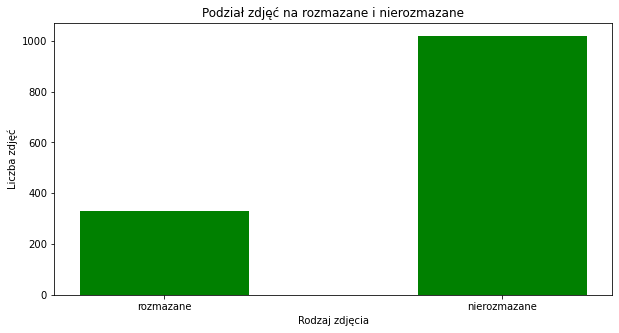

In [63]:
a = (sum_blurry, sum_notblurry)
b = ("rozmazane", "nierozmazane")
fig = plt.figure(figsize = (10, 5))
#  Bar plot
plt.bar(b, a, color ='green',
        width = 0.5)
plt.xlabel("Rodzaj zdjęcia")
plt.ylabel("Liczba zdjęć")
plt.title("Podział zdjęć na rozmazane i nierozmazane dla Normal")
plt.show()

In [65]:
sum_blurry = 0
sum_notblurry = 0
for i in range(len(Pneumonia)):
    image = cv2.imread(Pneumonia[i])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = variance_of_laplacian(gray)
    if fm < 100:
        sum_blurry += 1
    else:
        sum_notblurry +=1

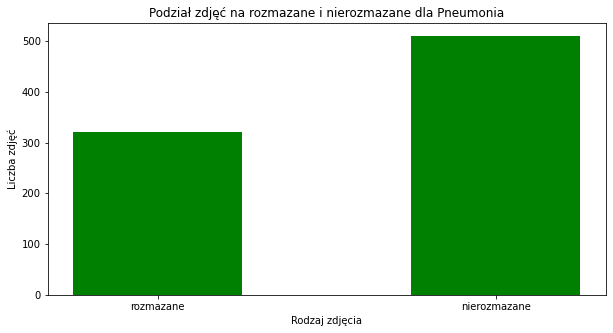

In [67]:
a = (sum_blurry, sum_notblurry)
b = ("rozmazane", "nierozmazane")
fig = plt.figure(figsize = (10, 5))
#  Bar plot
plt.bar(b, a, color ='green',
        width = 0.5)
plt.xlabel("Rodzaj zdjęcia")
plt.ylabel("Liczba zdjęć")
plt.title("Podział zdjęć na rozmazane i nierozmazane dla Pneumonia")
plt.show()

czy są artefakty (łańcuszki, guziki) na obrazach, przykłady - tylko pokaż może

Baza Pnumonia/normal

In [19]:
import cv2 as cv

zdj = cv2.imread(Pneumonia[40])
zdj2 = cv2.imread(Pneumonia[30])

Tu widzimy śrubkę

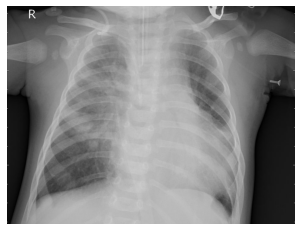

In [18]:
plt.imshow(zdj)
plt.axis("off")
plt.show()

czy jest aparatura medyczna (rurki, przewody) na zdjęciach

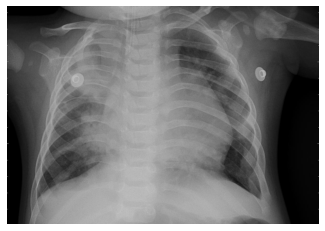

In [20]:
plt.imshow(zdj2)
plt.axis("off")
plt.show()

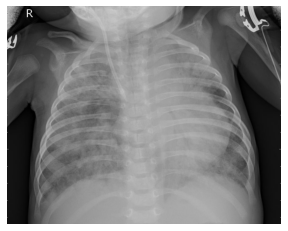

In [24]:
zdj3 = cv2.imread(Pneumonia[36])
plt.imshow(zdj3)
plt.axis("off")
plt.show()

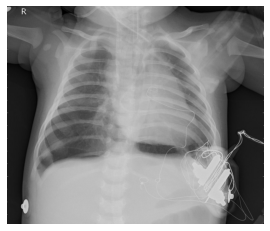

In [28]:
zdj3 = cv2.imread(Pneumonia[5])
plt.imshow(zdj3)
plt.axis("off")
plt.show()

Czy litery na obrazach?

Na niektórych są

czy są dane osobowe (imię, nazwisko, data urodzenia)

Nie ma 

Zdjęcia są jedno czy trzy kanałowe?

Zdjęcia jednokanałowe

Jak widac baza jest 1 kanałowa

rozmiary zdjęć, czy te same, czy różne <- rozkład

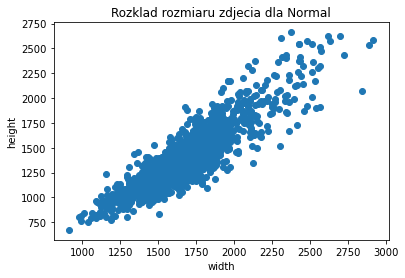

In [76]:
plt.scatter(width, height)
plt.title('Rozklad rozmiaru zdjecia dla Normal')
plt.xlabel('width')
plt.ylabel('height')
plt.savefig("zhong_size.png")
plt.show()

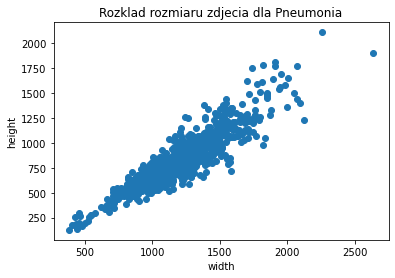

In [80]:
plt.scatter(width, height)
plt.title('Rozklad rozmiaru zdjecia dla Pneumonia')
plt.xlabel('width')
plt.ylabel('height')
plt.savefig("zhong_size.png")
plt.show()

różnice pomiędzy zbiorem treningowym a testowym

Brak podziału na treningowy i testowy

Jakość danych - 2 , nie posiadam, żadnych danych na temat zdjec jedynie są podzielone na 2 foldery, w Pneumonia mam duzo zdjec rozmazanych, zdjecia mają różnorodne rozmiary 

## ANALIZA OBRAZÓW

Histogram dla 10 zdjęć z obu klas

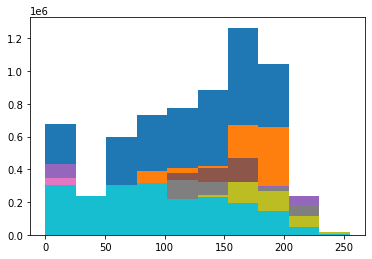

In [121]:
for i in range (10):
    img = cv2.imread(Normal[i],0)
    plt.hist(np.ravel(img))

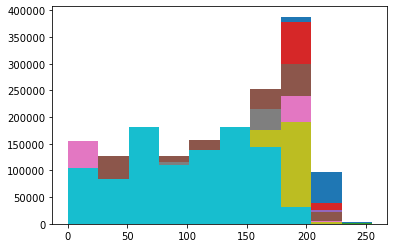

In [120]:
for i in range (10):
    img = cv2.imread(Pneumonia[i],0)
    plt.hist(np.ravel(img))

jakie są wartości pikseli w obrazach, czy w przedziale 0-1, czy 0-255, czy może inny zakres? czy każde zdjęcie ma wartości skrajne? jak sądzicie dlaczego tak jest?

biore przykladowe zdjecie

In [81]:
import cv2 as cv

zdj = cv2.imread(Normal[1])


In [82]:
xray_image = zdj
print("The data type of the X-ray image is: ", xray_image.dtype)
print("The minimum pixel value is: ", np.min(xray_image))
print("The maximum pixel value is: ", np.max(xray_image))
print("The average pixel value is: ", np.mean(xray_image))
print("The median pixel value is: ", np.median(xray_image))

The data type of the X-ray image is:  uint8
The minimum pixel value is:  0
The maximum pixel value is:  255
The average pixel value is:  128.9182897361231
The median pixel value is:  143.0


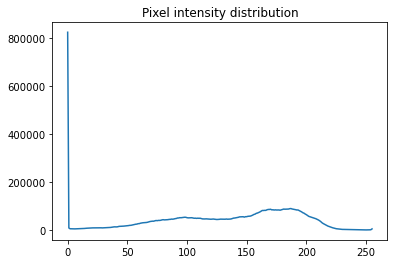

In [88]:
from scipy import ndimage
pixel_intensity_distribution = ndimage.histogram(
    xray_image, min=np.min(xray_image), max=np.max(xray_image), bins=256
)

plt.plot(pixel_intensity_distribution)
plt.title("Pixel intensity distribution")
plt.show()

Typ danych tablicy to uint8, a wyniki wartości minimalnej/maksymalnej sugerują, że wszystkie 256 kolorów (od 0 do 255) jest używanych w promieniowaniu rentgenowskim. Wizualizacja potwierdzila

czy wszystkie zdjęcia są monochrome2 lub monochrome1?

monochrome 1


czy wszystkie zdjęcia są dla pacjentów w pionie?

tak

# Mosmed
\*ze względu na ograniczenia sprzętowe część obliczeń jest zrobiona na ograniczonej ilości danych

# Dane jakościowe

Jakość obrazu

Do sprawdzenia jakości obrazu użyłem Brisque quality metric. Zdjęcia są w więskzości o bardzo dużej jakości. Niektóre obrazy mają mniejszy wynik ze względu na to, że sa mniej wyraziste: 

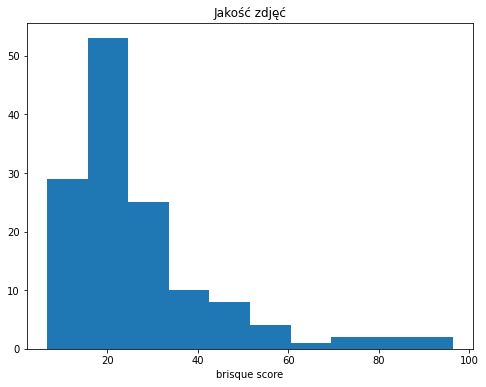

In [28]:
quality = pd.read_csv("../../KM1/wykresy_KM3/quality_mosmed.csv")

plt.figure( figsize=(8,6))
plt.hist(quality["quality"])
plt.title("Jakość zdjęć")
plt.xlabel("brisque score")
plt.show()

czy są dane osobowe (imię, nazwisko, data urodzenia)

Nie

czy zdjęcia są jedno czy trzy kanałowe

Zdjęcia są 3D. Są jedno kanałowe. Zakres wynosi od -2048 do 32346.

czy są artefakty (łańcuszki, guziki) na obrazach, przykłady - tylko pokaż może

Idąc z założenia,że artefakty będą najjaśniejszymi elementami zdjęć sprawdziłem zdjęcai o najjaśniejszych wartościach i nie znalazłem żadnych artefaktów.

rozmiary zdjęć, czy te same, czy różne <- rozkład

Długość i szerokość zdjęć jest taka sama. Głębokość się różni:

jakość danych - oceńcie wspólnie w skali od 1 do 5 i uzasadnijcie

Oceniam na 5. Zdjęcai są bardzo dokładne, jak wymagałaby tomografia komputerowa. Są zdjęcaimi 3D z szerokim zakresem kolorów.

czy są jakieś skale pewności np. annotacji?

Brak

## Analiza obrazu

### Pomocne własności zdjęc tomografii

In [90]:
import os
import nibabel as nib

DATA_PATH = "../../KM1/mosmed/COVID19_1110/"
MASKS_PATH = "masks/"
STUDIES_PATH = "studies/"
# read all studies nifti data
studies_dirs_list = os.listdir(DATA_PATH+STUDIES_PATH)
studies = {}


for st_dir in studies_dirs_list: 
    if (st_dir=='.DS_Store'):
        continue
    dirs_list = os.listdir(DATA_PATH+STUDIES_PATH+st_dir)
    n = len(dirs_list)
    stud = [None] * n
    for i in range(n):
        stud[i] = nib.load(DATA_PATH+STUDIES_PATH+st_dir+"/"+dirs_list[i])
    studies[st_dir]=stud
    
df_lim = pd.DataFrame({"CT": [], "image":[]})

for ct in studies: 
    for i in range(int(len(studies[ct])/8)):
        new = pd.DataFrame({"CT": ct, "image": studies[ct][i]}, index=[0])
        df_lim = pd.concat([df_lim, new])
    
df_lim = df_lim.reset_index(drop=True)
#df_lim.head(5)

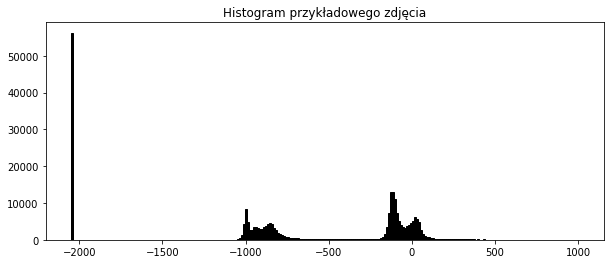

In [80]:
to_draw = df_lim.iloc[2][1]

plt.figure(figsize=(10,4)) 
plt.title("Histogram przykładowego zdjęcia")
plt.hist(to_draw.get_fdata()[:,:,15].ravel(), range=(-2050.0, 1000.0),bins=256, fc='k', ec='k') #calculating histogram
plt.show()

Można zauważyć trzy oddzielne grupy. na początku jest wartość-2048, która nie zawiera żadnych informacji i jest tam tylko dlatego, bo naszę zdjęcia są okręgami. Następnie są wartości ok [-1500, -500], które "reprezuntują" powietrze. Natomiast od -500 w górę mamy materiały oraz ciało. Co ciekawe nawet zdjęcia, które miały gorszą jakość (wynik brisque) wciąż pokazują podobną zależność A więc możemy uprościć naszę zdjęcia zapisując wartości <=-500 jako 0, a > 500 jako 1:

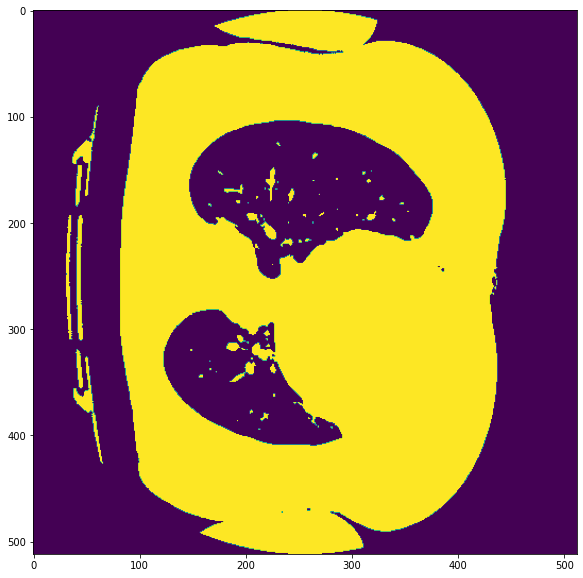

In [81]:
import copy
a = copy.deepcopy(to_draw.get_fdata()[:,:,15])
l = -500
a[a>l] = 1
a[a<=l] = 0

plt.figure(figsize=(1, 1)) 
plt.imshow(a)
plt.gcf().set_size_inches(10, 10)
#ax.set_title("CT-"+str(0), fontsize=24)
plt.show()

czy wszystkie zdjęcia są dla pacjentów w pionie?

Wszystkie zdjęcia są zapisane w tej samej orientacji. Aby to sprawdzić wziąłem środkowe zdjęcie tomografii i następnie wziąłem środkowy poziomy pasek naszego zdjęcia. Przkształciłem ten obszar na formę {0.1} i obliczyłem ile miejsca zajmują jedynki. W teorii, jeśli zdjęcie miałoby być pionowę, to powinno być więcej zer w wybranym obszarze, ponieważ znajdowałyby sie tam płuca.

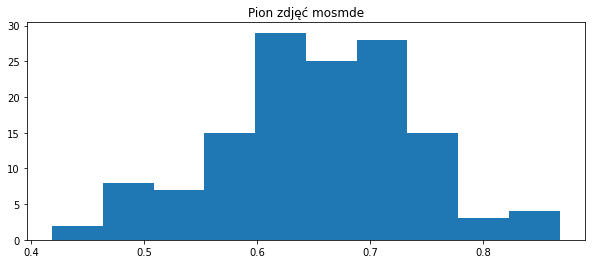

In [82]:
df_lim_v = pd.read_csv("../../KM1/wykresy_KM3/df_lim_mosmed.csv")

plt.figure( figsize=(10,4))
plt.title("Pion zdjęć mosmde")
plt.hist(df_lim_v["vertical"])
plt.show()

Następnie sprawdziłem podobną metodą, czy zdjęcia mają po swojej lewej stronie płuca. Brałem środkowe zdjęcie tomografii i zmieniałem je na formę {0,1}. Następnie liczyłem ilośćjedynej lewej strony zdjęcia oraz prawej połowki zdjęcia. Wyszło mi, że żadne zdjęcie nie posiada więcej jedynek po lewej stronie zdjęcai, co wskazuje na to, że wszystkie płuca są po lewej stronie.

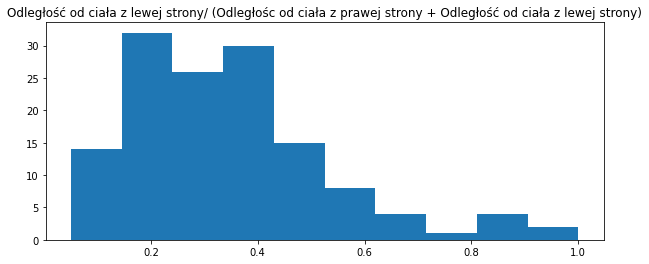

In [83]:
plt.figure( figsize=(10,4))
plt.title("Odległość od ciała z lewej strony/ (Odległośc od ciała z prawej strony + Odległość od ciała z lewej strony)")
plt.hist(df_lim_v["wsp przechylenia"])
plt.show()

Przprowadziłem również analizę, czy zdjęcia znajdują sie na środku obrazu. Srawdziłem to w bardzo podobny sposob do pozostałych, tylko, że zamiast obliczać ilość jedynek, patrzyłem na pierwsze i kolumnę pierwszego i ostatniego pojawienia się jedynki. W ten sposób udało mi się znależć kilk zdjęć, które mają płuca z boku obrazu. Równocześnie udało mi się znależć zdjęcia, które nie posiadaja całości ciała otaczającego klatkę piersiową:

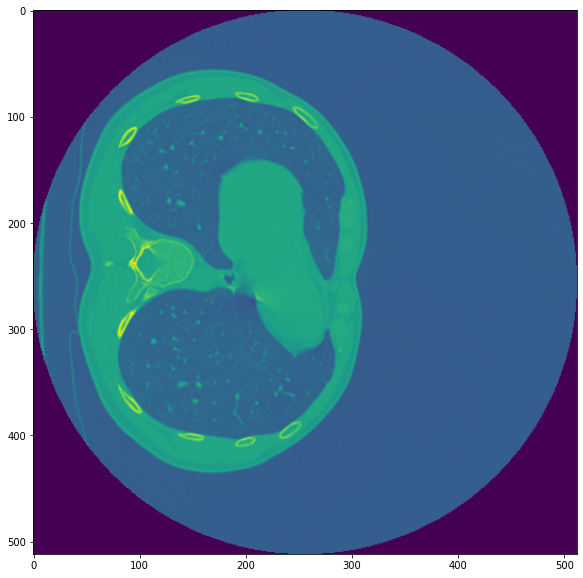

In [87]:
to_draw = df_lim.iloc[54][1]

plt.figure(figsize=(5, 5)) 
plt.imshow(to_draw.get_fdata()[:,:,15])
plt.gcf().set_size_inches(10, 10)
#ax.set_title("CT-"+str(0), fontsize=24)
plt.show()

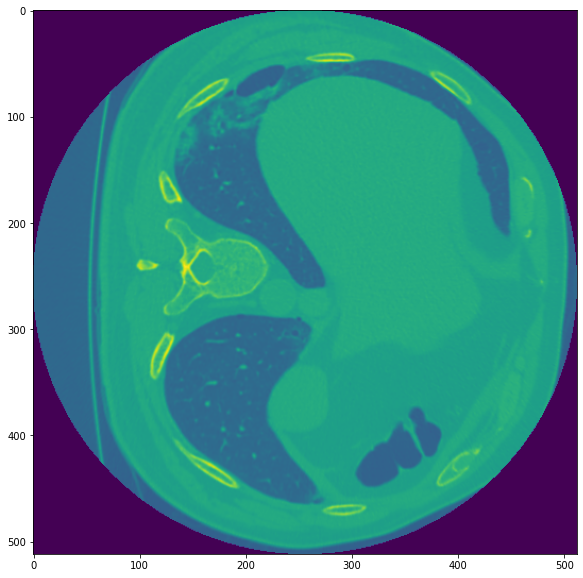

In [89]:
to_draw = df_lim.iloc[95][1]

plt.figure(figsize=(5, 5)) 
plt.imshow(to_draw.get_fdata()[:,:,15])
plt.gcf().set_size_inches(10, 10)
#ax.set_title("CT-"+str(0), fontsize=24)
plt.show()

### Maski

In [69]:
# read all masks nifti data
masks_dir_list = os.listdir(DATA_PATH+MASKS_PATH)
n_masks = len(masks_dir_list)
masks = [None] * n_masks

for i in range(n_masks):
    masks[i] = nib.load(DATA_PATH+MASKS_PATH+masks_dir_list[i])

czy mamy podstawy sądzić, że np. zaznaczono tylko jedną zmianę/chorobę zamiast wszystkich? uzasadnienie

Mamy dostępnę 50 masek. Wszystkie maski są z klasy CT-0. Najpierw sprawdźmy, czy nasze maski się nakładają z zdjęcaimi

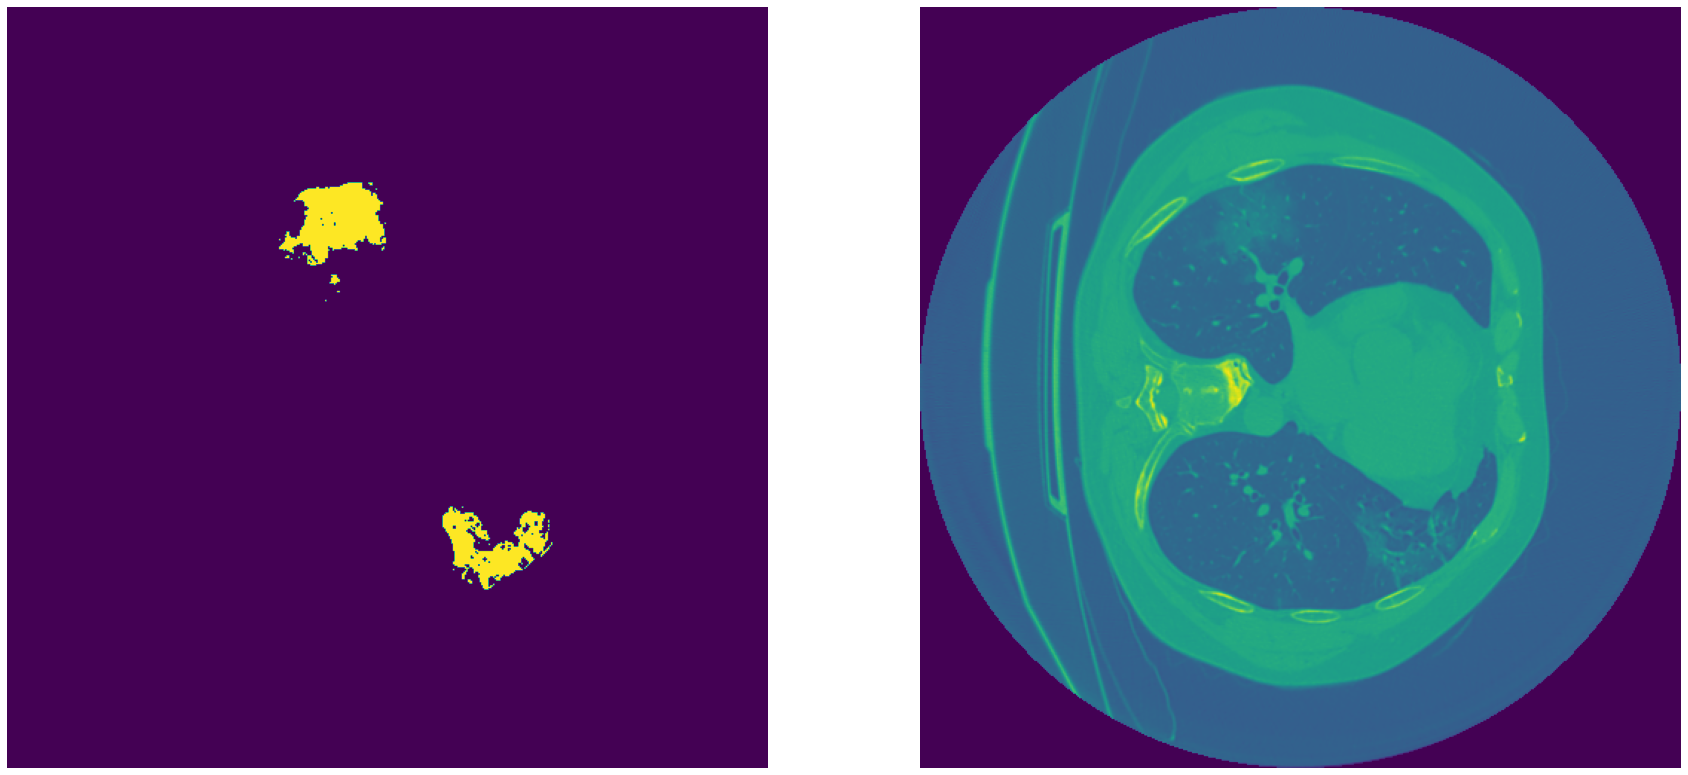

In [71]:
to_draw = studies["CT-1"][0]

#plt.gcf().set_size_inches(30, 30)
#ax2.set_title("CT-"+str(1), fontsize=24)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

plt.gcf().set_size_inches(30, 30)
ax1.imshow(masks[0].get_fdata()[:,:,15])
ax1.axis('off')

ax2.imshow(to_draw.get_fdata()[:,:,15])
ax2.axis('off')

plt.show()



#ax.set_title("CT-"+str(0), fontsize=24)
plt.show()

Następnie sprawdżmy najczęstszą lokalizację zmiany:

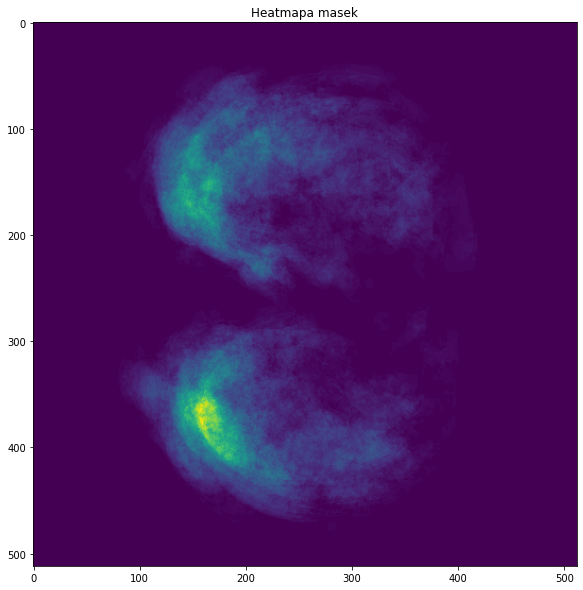

In [77]:
m = [[0]*512]*512
for mask in masks:
    for i in range(mask.get_fdata().shape[2]):
        m += mask.get_fdata()[:,:,i]
plt.imshow(m)
plt.title("Heatmapa masek")
plt.gcf().set_size_inches(10, 10)
plt.show()

Możemy również sprawdzić jak duży obszar jest zaznaczany jako anomalia:

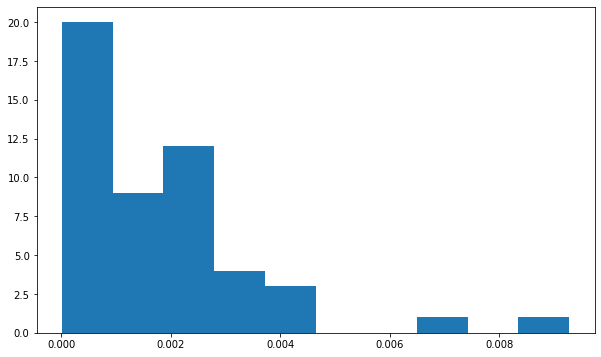

In [75]:
df_mask = pd.DataFrame({"image": masks})
df_mask.head(10)
n_mask = len(df_mask)
mean_mask = [None] * n_mask


for  i in range(n_mask):
    #print("Jest wykonywana operacja: ", i, "/", n_mask, " ; ", i/n_mask*100, "%")
    mean_mask[i] =  np.mean(df_mask["image"][i].get_fdata())

plt.figure( figsize=(10,6))
plt.title("")
plt.hist(mean_mask)
plt.show()

# Reflacx

## Analiza tekstu

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

Najpierw zobaczmy jak jest średnia długość diagnozy

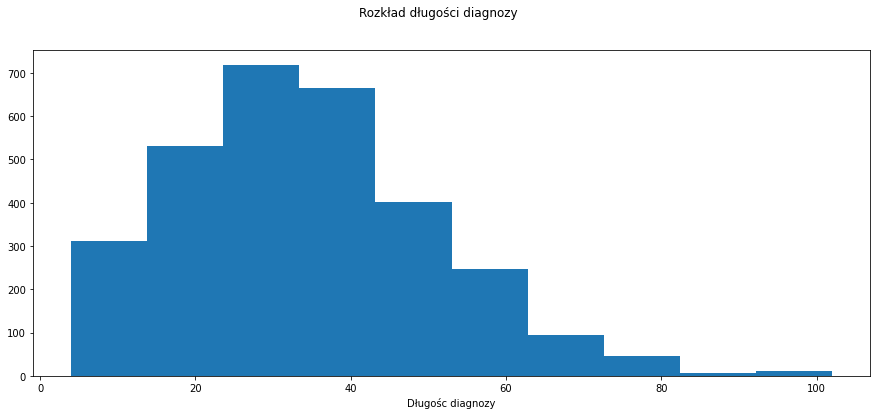

In [12]:
diagnosis_length = pd.read_csv("../../KM1/wykresy_KM3/dignosis_length_reflacx.csv")

plt.figure( figsize=(15,6))

plt.hist(diagnosis_length["length"])
plt.xlabel("Długośc diagnozy")
plt.suptitle("Rozkład długości diagnozy")

plt.show()

Najdłuższy opis wygląda w ten sposób:

*endotracheal tube tip projects over the upper-mid trachea. right ij cvc tip projects over the mid svc. left ij approach pulmonary arterial catheter projects over the proximal right pulmonary artery. feeding tube and gastric tube courses below the diaphragm and beyond the field of view. catheter versus external wire projects over the upper right abdomen. retrocardiac left basilar parenchymal opacity favored to represent atelectasis. perihilar ground-glass opacities may represent pulmonary edema or atelectasis. possible small left pleural effusion. no pneumothorax. cardiomediastinal silhouette is within normal for technique. no acute osseous abnormality.*


Wynika z tego, że nasze opisy powinny być wartościowe. W takim razie sprawdźmy, które słowa się najczęściej powtarzają: 

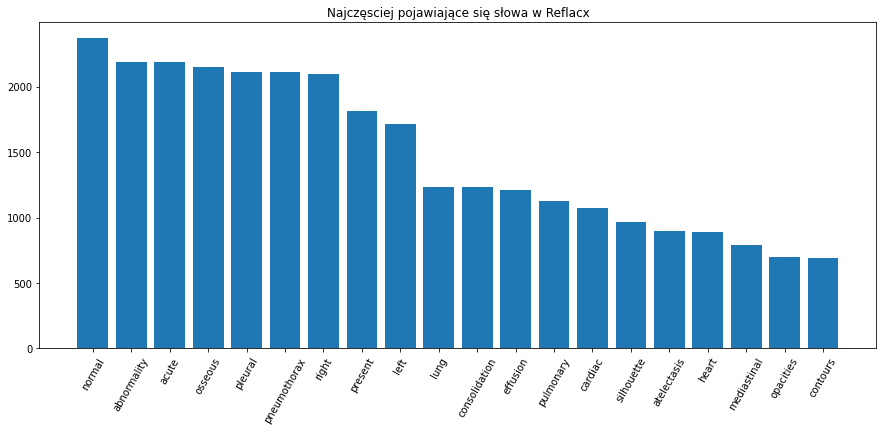

In [22]:
word_amounut = pd.read_csv("../../KM1/wykresy_KM3/word_amounut_reflacx.csv")


plt.figure(figsize=(15,6))
plt.title("Najczęsciej pojawiające się słowa w Reflacx")
plt.bar(word_amounut["word"], word_amounut["counts"])
plt.xticks(rotation = 60)
plt.show()

Sprawdźmy również najbardziej kluczowe słowa: 

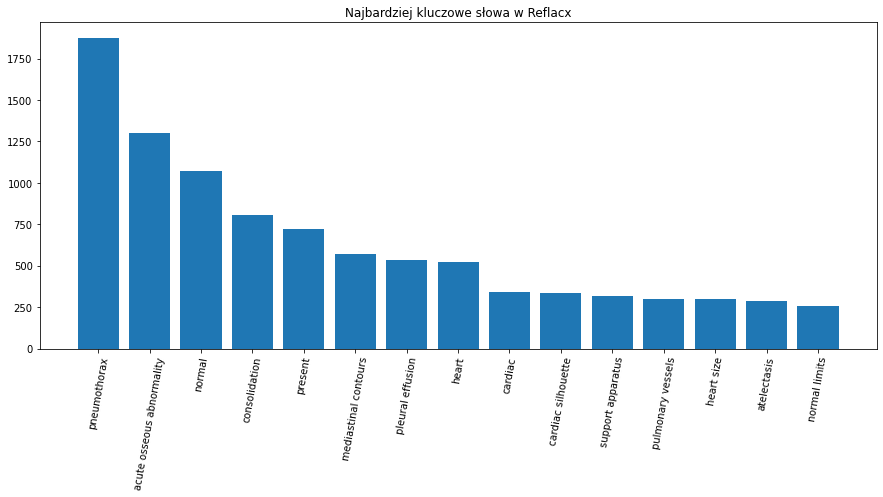

In [23]:
a_keyph = pd.read_csv("../../KM1/wykresy_KM3/keyphrases_reflacx.csv")

plt.figure(figsize=(15,6))
plt.title("Najbardziej kluczowe słowa w Reflacx")
plt.bar(a_keyph["0"], a_keyph["counts"])
plt.xticks(rotation = 80)
plt.show()

Zobaczmy jak wyglądają wspólczynniki Flesh reading ease oraz Flesh-Kincaid grade level

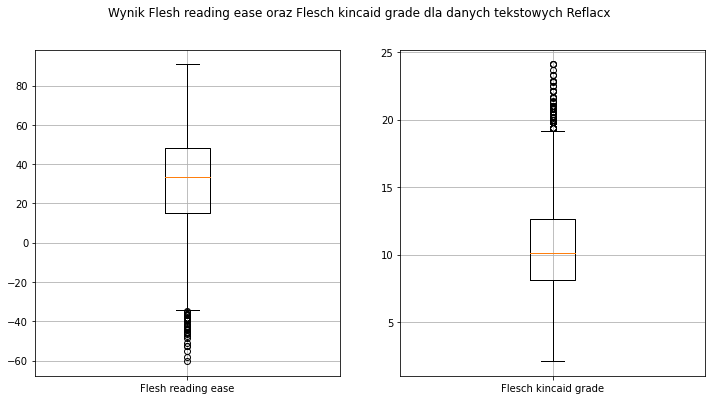

In [24]:
flesch_dict = pd.read_csv("../../KM1/wykresy_KM3/flesch_dict.csv")

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.grid()

ax1.boxplot(flesch_dict["Flesh reading ease"])
ax1.set_xticklabels(["Flesh reading ease"])

ax2.grid()

ax2.boxplot(flesch_dict["Flesch kincaid grade"])
ax2.set_xticklabels(["Flesch kincaid grade"])
plt.suptitle("Wynik Flesh reading ease oraz Flesch kincaid grade dla danych tekstowych Reflacx")



plt.show()

W Flesh reading ease im wyższe wartości tym łatwiejsze do odczytania. Mozemy z wykresu odczytać, że nasze opisy są często ciężkkie do odczytania. Jest to ze względu na to, że doktorzy przy opisie anomalii często posługują się profesjonalnymi zwrotami oraz skrótami myślowymi. 


# siim covid 19

## Dane jakościowe

jakość zdjęć według brisque score, porównanie ze względu na występowanie choroby pokazuje, że jakością zdjęcia nie różnią się znacząco między klasami, jeśli chodzi o podział ze względu na `appearance`, sytuacja podobnie, rozkłady praktycznie nie różnią się położeniem.

<img src="./wykresy/siim_image_quality_by_pneumonia.svg">

<img src="./wykresy/siim_image_quality_by_atypical.svg">

czy zdjęcia między klasami i między bazami danych się różnią czymś poza płucami (?)

Niespecjalnie, dla mnie zdjęcia chorych/z atypowościami nie różnią się od tych zdrowych

czy dużo zdjęć rozmazanych. sprawdzenie ostrości zdjęcia // https://pyimagesearch.com/2015/09/07/blur-detection-with-opencv/

<img src="./wykresy/siim_blur.svg">

artefakty, aparatura medyczna na zdjęciach - przykład:

Na zdjęciu widoczna aparatura medyczna
<img src="./wykresy/siim_aparature_example.svg">

czy litery na obrazach, przykład; wykryć, czy występują litery na obrazku + kod do tego. ile tego jest?

litery na obrazach pojawiają się (powyższy przykład), natomiast nie udało się wykrywać tego przy pomocy modułu `tesseract`

czy mamy podstawy sądzić, że np. zaznaczono tylko jedną zmianę/chorobę zamiast wszystkich?uzasadnienie

nie mamy zaznaczonych zmian chorobowych, a jedynie klasyfikację zdjęć na te, z atypowością lub jej brakiem

czy są dane osobowe (imię, nazwisko, data urodzenia)

Nie mamy praktycznie żadnych danych osobowych, wszystkie zostały zamazane w pliku dicom

rozmiary zdjęć, czy te same, czy różne <- rozkład

<img src="./wykresy/siim_image_sizes.svg">

czy są jakieś skale pewności np. annotacji?

nie ma

## ANALIZA OBRAZÓW

czy po histogramie można rozróżnić, z której klasy jest dane zdjęcie? wygenerować histogram wraz z odchyleniami od średniej dla każdej klasy

<img src="./wykresy/siim greyscale histogram.svg">

<img src="./wykresy/siim_mean_std_plot.svg">

jeśli są dane tego samego pacjenta z różnych dni to zmierzyć różnicę pomiędzy obrazami.

nie mamy czasu badania, mamy kilka zdjęć tego samego pacjenta w bazie  
okazuje się, że są to identyczne zdjęcia.

jakie są wartości pikseli w obrazach, czy w przedziale 0-1, czy 0-255, czy może inny zakres? czy każde zdjęcie ma wartości skrajne? jak sądzicie dlaczego tak jest?

przykładowe zdjęcie:  
`The data type of the X-ray image is:  uint16
The minimum pixel value is:  0
The maximum pixel value is:  3631
The average pixel value is:  2229.750781603835
The median pixel value is:  2234.0`

ani w jednej ani w drugiej bazie nie potrafię określić w zakresie są wartości pikseli.
zdjęcia trafiają się z naprawdę różnym rozkładem, czasem używane są wartości z krańca przedziału, czasem nieszczególnie

czy są zdjęcia z dziwnie przesuniętym histogramem?

<img src="./wykresy/siim_histogram_shifted.svg">

histogram powyżej to histogram dla tego zdjęcia:

<img src="./wykresy/siim_histogram_shifted_image.svg">

czy są zdjęcia nie na środku okna (np. mocno z boku lub dołu)

widziałem takie, nie mam pojęcia jak je wykryć

# luna16

W bazie danych Luna-16 rozkład próbki zdjęć wygląda tak:
<img src="./wykresy/luna_16_quality_of_image.svg">

czy dużo zdjęć rozmazanych. sprawdzenie ostrości zdjęcia // https://pyimagesearch.com/2015/09/07/blur-detection-with-opencv/

<img src="./wykresy/luna_blur.svg">

mamy dużo zdjęć, które miałyby być rozmazane, ale to nie prawda. niższy wynik przyporządkowany został tym zdjęciom, które mają mniej wyraźny kontrast.

nie ma liter na zdjęciach

czy są dane osobowe (imię, nazwisko, data urodzenia)  
wszystko jest zakodowane, w celu ochrony danych

rozmiary zdjęć - mamy tylko różnicę w liczbie zdjęć w skanie

Najczęstsze występowanie zmiany w płucach:
<img src="./wykresy/annotation_location.svg">

wykres przypomina płuca